In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 150
plt.style.use('ggplot')

import seaborn as sns
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("husl", 8));

In [2]:
cd ../

/Users/toz/Documents/workspace/Circle-of-Doom


In [3]:
# Published News (retrieved from Lexis Nexis)
pn = pd.read_csv('data/ln-sp.csv')
outlets = sorted(pn['outlet'].unique().tolist())

In [4]:
# Tweeted News
tn = pd.read_csv('data/tw-sp.csv',usecols=['dt', 'outlet', 'rt', 'sp', 'href'])

In [6]:
# Retweeted News
rn = pd.DataFrame(columns=tn.columns)
for row in tn.iterrows():
    rn = rn.append(pd.DataFrame([row[1]]*int(1 + row[1].rt/50)))

# Part 1

## Number of Retweets Per Outlet

In [7]:
pd.pivot_table(tn,index=['outlet'],values=['rt'],aggfunc=[np.mean,max,np.median]).rename(columns={'rt':'Retweet'})

,mean,max,median
,Retweet,Retweet,Retweet
outlet,,,
ABC,168.017834,5201,101
AP,89.845301,862,70
CBSNews,72.674347,2458,49
CNN,360.776088,7752,218
FoxNews,134.125313,3122,89
NBCNews,85.501179,11031,55
NYT,142.722276,8917,85
WPOST,83.014623,3683,59


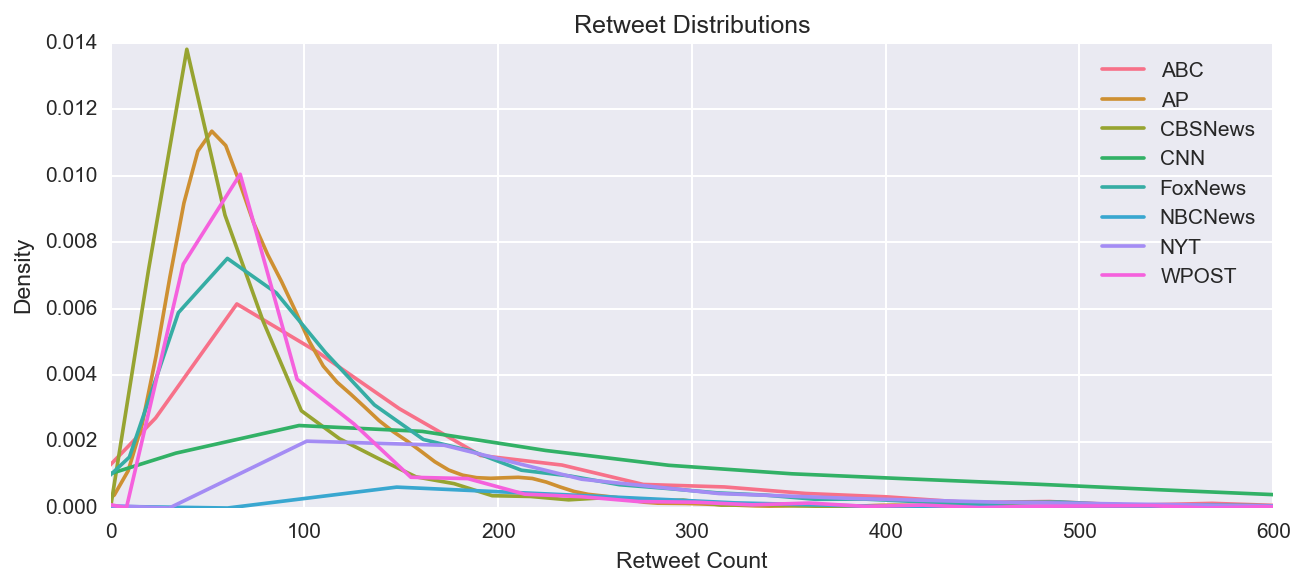

In [8]:
sns.mpl.rc("figure", figsize=(10,4))
ax = [sns.kdeplot(tn[tn.outlet==o].rt,label=o) for o in outlets][0]
ax.set(xlim=(0,600))
ax.set_title('Retweet Distributions')
ax.set_xlabel('Retweet Count')
ax.set_ylabel('Density')
plt.savefig('figs/RT-dist.png')

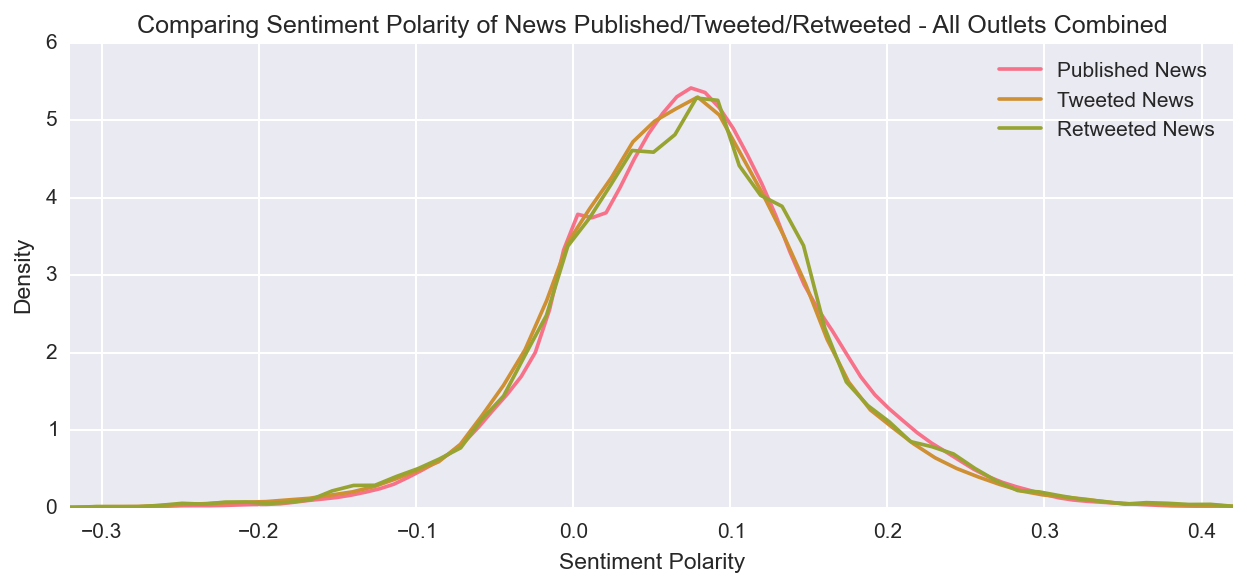

In [9]:
splim=(-.32, .42)
sns.mpl.rc("figure", figsize=(10,4))

sns.kdeplot(pn['sp'],label='Published News').set(xlim=splim)
sns.kdeplot(tn['sp'],label='Tweeted News').set(xlim=splim)
ax = sns.kdeplot(rn['sp'],label='Retweeted News')
ax.set_title('Comparing Sentiment Polarity of News Published/Tweeted/Retweeted - All Outlets Combined')
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Density')
plt.savefig('figs/sentiment-comparison-published-tweeted-retweeted.png',bbox_inches='tight')

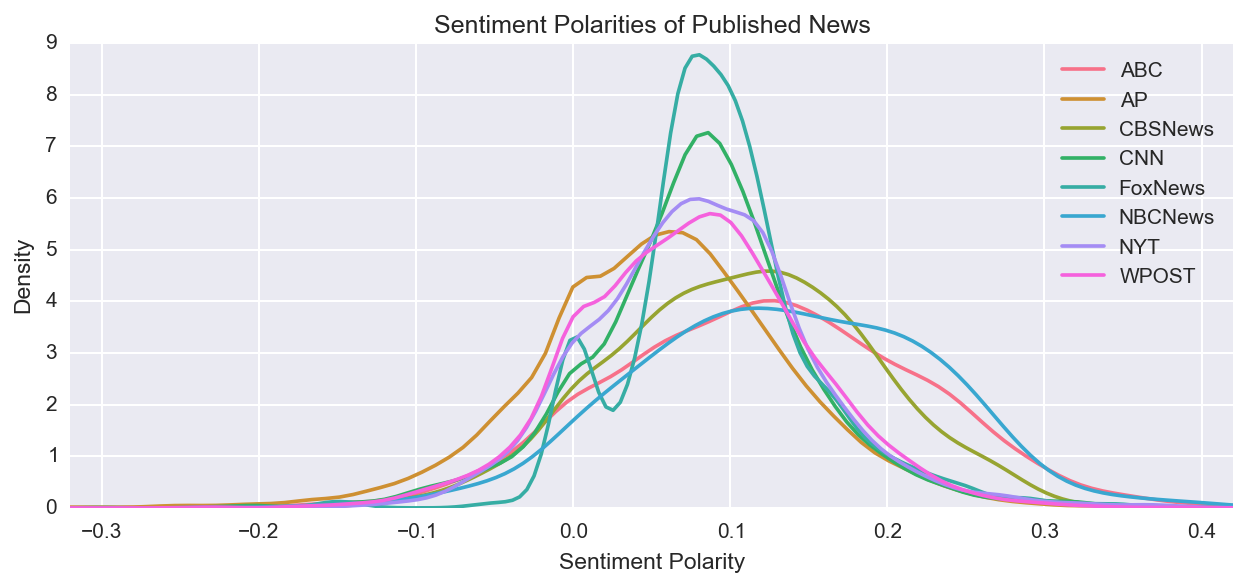

In [10]:
df = pn
ax = [sns.kdeplot(df[df['outlet']==o]['sp'],label=o) for o in outlets][0]
ax.set(xlim=splim) # = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Published News')
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Density')
plt.savefig('figs/sentiment-published.png',bbox_inches='tight')

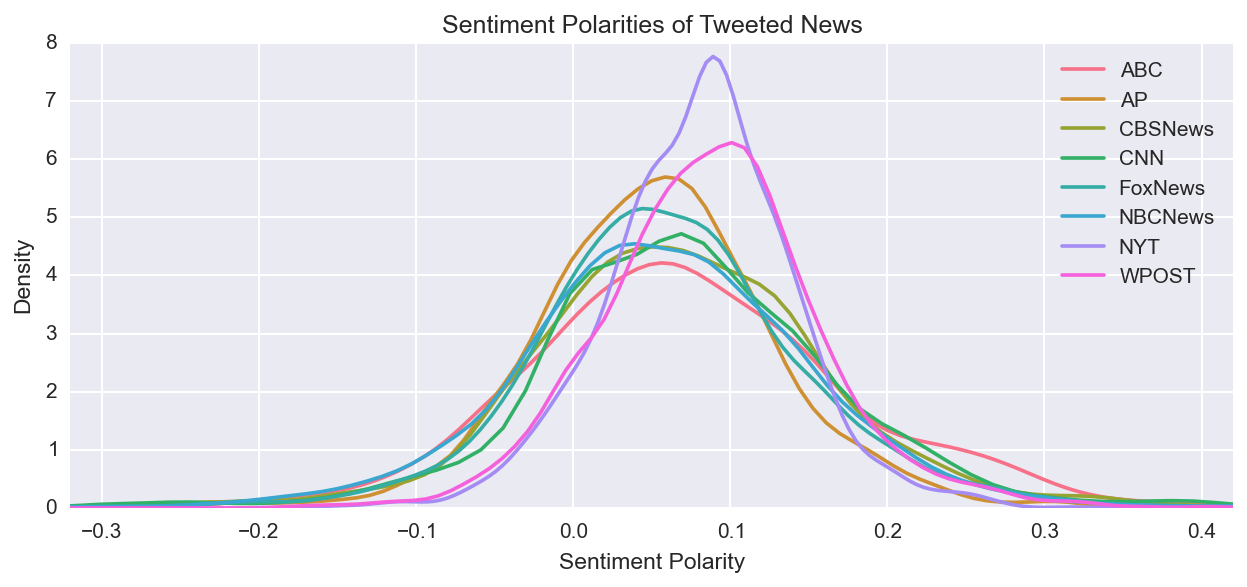

In [11]:
df = tn
ax = [sns.kdeplot(df[df['outlet']==o]['sp'],label=o) for o in outlets][0]
ax.set(xlim=splim) # = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Tweeted News')
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Density')
plt.savefig('figs/sentiment-tweeted.png',bbox_inches='tight')

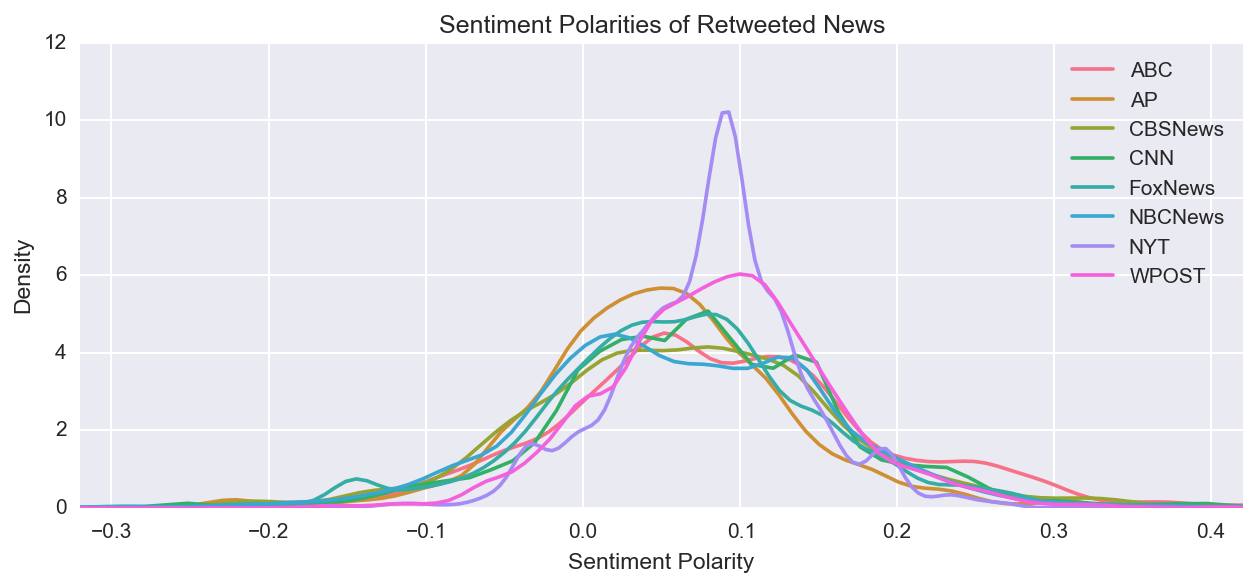

In [12]:
df = rn
ax = [sns.kdeplot(df[df['outlet']==o]['sp'],label=o) for o in outlets][0]
ax.set(xlim=splim) # = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Retweeted News')
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Density')
plt.savefig('figs/sentiment-retweeted.png',bbox_inches='tight')

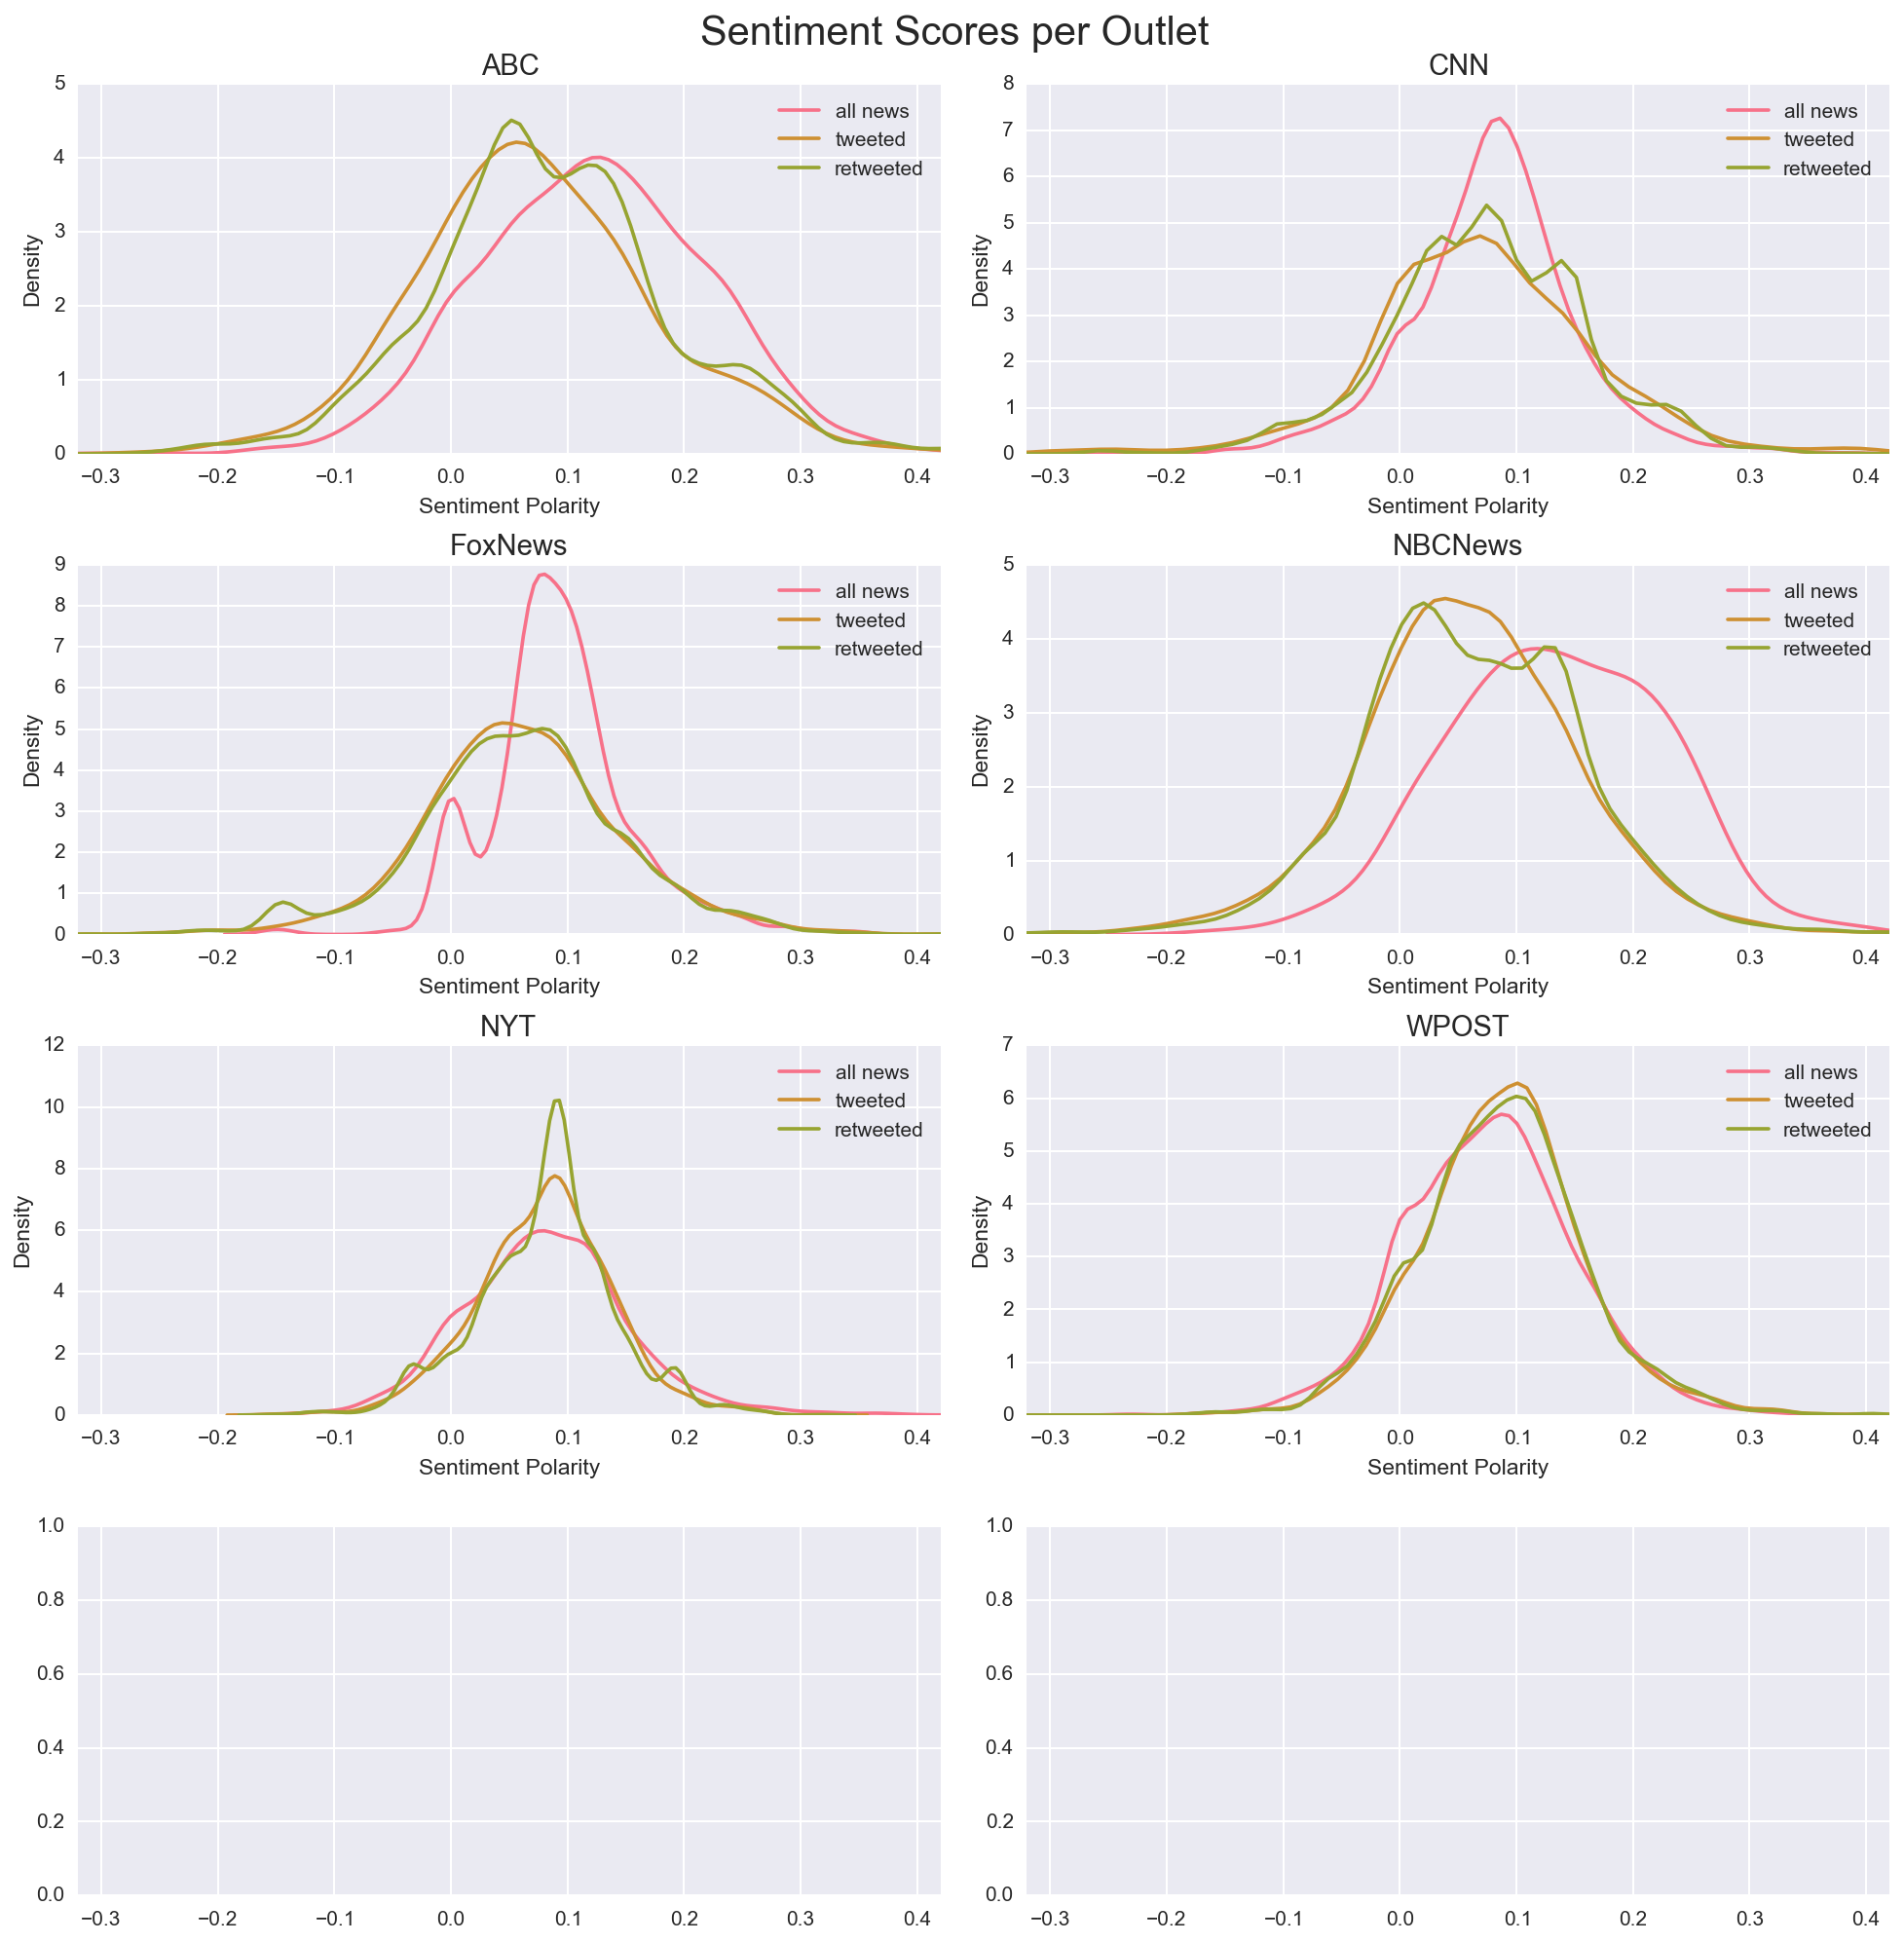

In [23]:
# Each outlet in a separate plot
f,axes = plt.subplots(nrows=4,ncols=2,figsize=(16,16),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
#f.tight_layout(h_pad=4,rect=(0,0,1,0.97))
plt.subplots_adjust(hspace=0.3,wspace=0.1)
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o,fontsize=14)
    ax.set_xlabel('Sentiment Polarity')
    ax.set_ylabel('Density')
    sns.kdeplot(pn[pn['outlet']==o]['sp'],label='all news',ax=ax)
    sns.kdeplot(tn[tn['outlet']==o]['sp'],label='tweeted',ax=ax)
    sns.kdeplot(rn[rn['outlet']==o]['sp'],label='retweeted',ax=ax)
f.suptitle('Sentiment Scores per Outlet', fontsize=20,y=0.93)
plt.savefig('figs/sentiment-per-outlet.png',bbox_inches='tight')

In [15]:
df = pd.pivot_table(pn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Published'})
df = df.join(pd.pivot_table(tn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Tweeted'}))
df = df.join(pd.pivot_table(rn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Retweeted'}))
df

,Published,Tweeted,Retweeted
outlet,,,
ABC,0.121289,0.073424,0.086552
AP,0.056630,0.052039,0.049722
CBSNews,0.107229,0.068442,0.065489
CNN,0.079748,0.071030,0.074590
FoxNews,0.092249,0.061333,0.065008
NBCNews,0.133630,0.058080,0.062377
NYT,0.081869,0.080523,0.081503
WPOST,0.076985,0.087476,0.086371


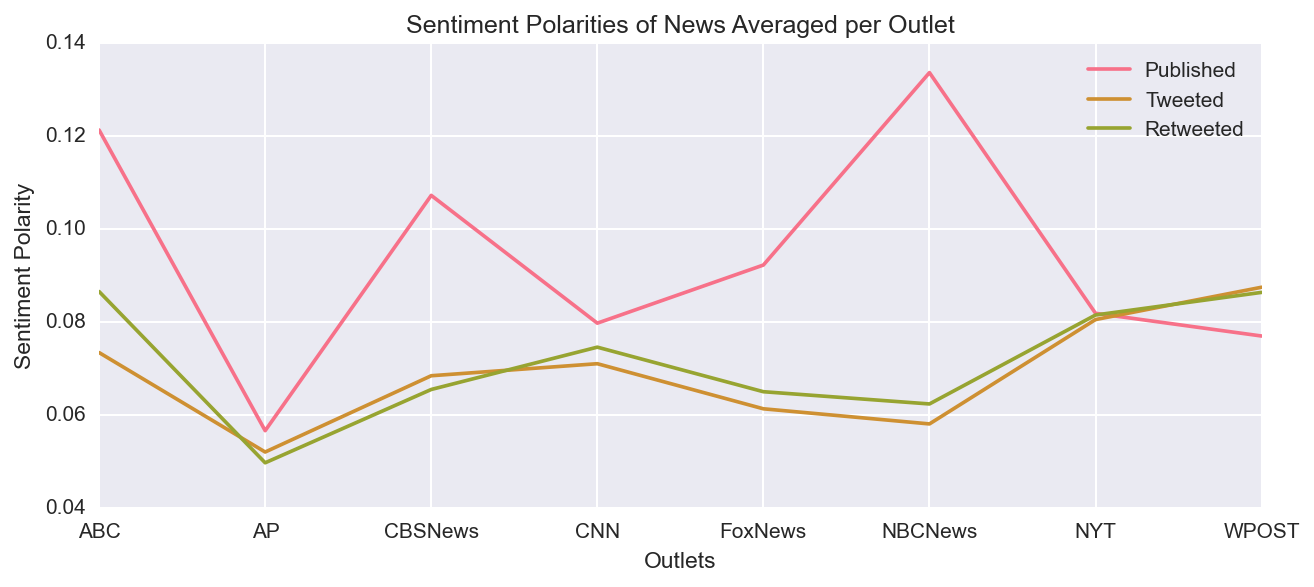

In [16]:
ax = df.plot()
ax.set_title('Sentiment Polarities of News Averaged per Outlet')
ax.set_ylabel('Sentiment Polarity')
ax.set_xlabel('Outlets')
plt.savefig('figs/sentiment-averages-per-outlet.png',bbox_inches='tight')

#Part 2

In [17]:
def getCat(x):
    pieces = [piece.lower() for piece in x.href.split('/')]
    
    if x.outlet == 'CNN':
        return pieces[-3]
    elif x.outlet == 'NYT':
        if pieces[-2]=='international':
            return 'world'
        if 'ball' in pieces[-2]:
            return 'sports'
        return pieces[-2]
    elif x.outlet == 'ABC':
        if pieces[3]=='international':
            return 'world'
        return pieces[-3]
    elif x.outlet == 'NBCNews':
        if pieces[3]=='news':
            return pieces[4] if pieces[4]!='us-news' else 'us'
        if pieces[3]=='meet-the-press':
            return 'interview'
        return pieces[3]
    elif x.outlet == 'CBSNews':
        return pieces[-3]
    elif x.outlet == 'FoxNews':
        return pieces[3]
    elif x.outlet == 'AP':
        return pieces[-3]
    elif x.outlet == 'WPOST':
        return pieces[3] if pieces[3]!='pb' else pieces[4]

df = tn #pd.read_csv('data/tw-sp.csv')
print('Header:',', '.join(df.columns.values))
print('Number of rows and columns:',df.shape)
df = df[~df.href.str.contains('/videos/')] #CNN
df = df[(df.outlet != 'FoxNews') | ((df.outlet == 'FoxNews') & (df.href.str.contains('www.foxnews.com')))] #Fox
df['cats'] = df.apply(getCat,axis=1)
category = pd.pivot_table(df,index=["cats"],values=["href"],aggfunc=len).sort('href',ascending=False)
bf= df[df.cats.isin(category[category.href>50].index)]
b = pd.pivot_table(bf,index=["cats"],columns=['outlet'],values=["href"],aggfunc=len)
b.fillna('')

Header: dt, outlet, rt, sp, href
Number of rows and columns: (16530, 5)


href                                              
outlet         ABC    AP CBSNews  CNN FoxNews NBCNews  NYT WPOST
cats                                                            
americas                           23                   31      
article             1868                                        
asia                               60               2   82      
blogs                                                       1237
business        47                  1             160   72    27
economy                            37                   27      
entertainment  123                112     157                 14
europe                             61               5  109      
health         166                 59     101      81   25      
interview                                          83           
leisure                                    57                   
lifestyle       68                                            65
living                             85                           
local                                                         97
magazine                                               108      
media                              45                   29      
middleeast                         74                  106      
news             1          1952   15                        756
nyregion                                               177      
opinion                            46      37           55      
politics       156                323     515      78  112   139
pop-culture                                        69           
science                                    45     145   54      
sports          52                         60      31  107     9
storyline                                         411           
tech                               18      54     122           
technology     108                 51                   41      
travel          16                 34      16           38      
upshot                                                  75      
us             507                351     475     739  264      
weather                                    24      54           
world          265                109     334     384   57   210

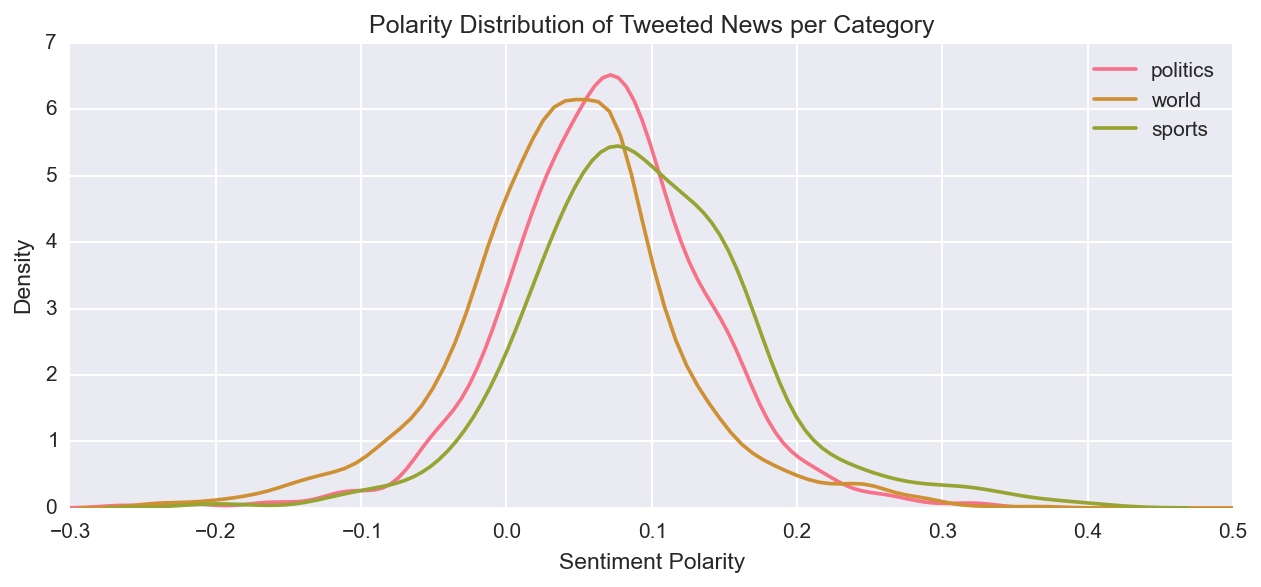

In [18]:
cs = ['politics','world','sports']
ax = [sns.kdeplot(df[df['cats']==c]['sp'],label=c) for c in cs][0]
ax.set_title('Polarity Distribution of Tweeted News per Category')
ax.set(xlim=(-0.3,0.5))
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Density')
plt.savefig('figs/tweeted-politics-world-sports.png',bbox_inches='tight')

In [20]:
# Retweeted News
rn = pd.DataFrame(columns=df.columns)
for row in df.iterrows():
    rn = rn.append(pd.DataFrame([row[1]]*int(1 + row[1].rt/50)))

In [21]:
#these outlets do not have any topic category tagged in our dataset
outlets.remove('AP')
outlets.remove('CBSNews')

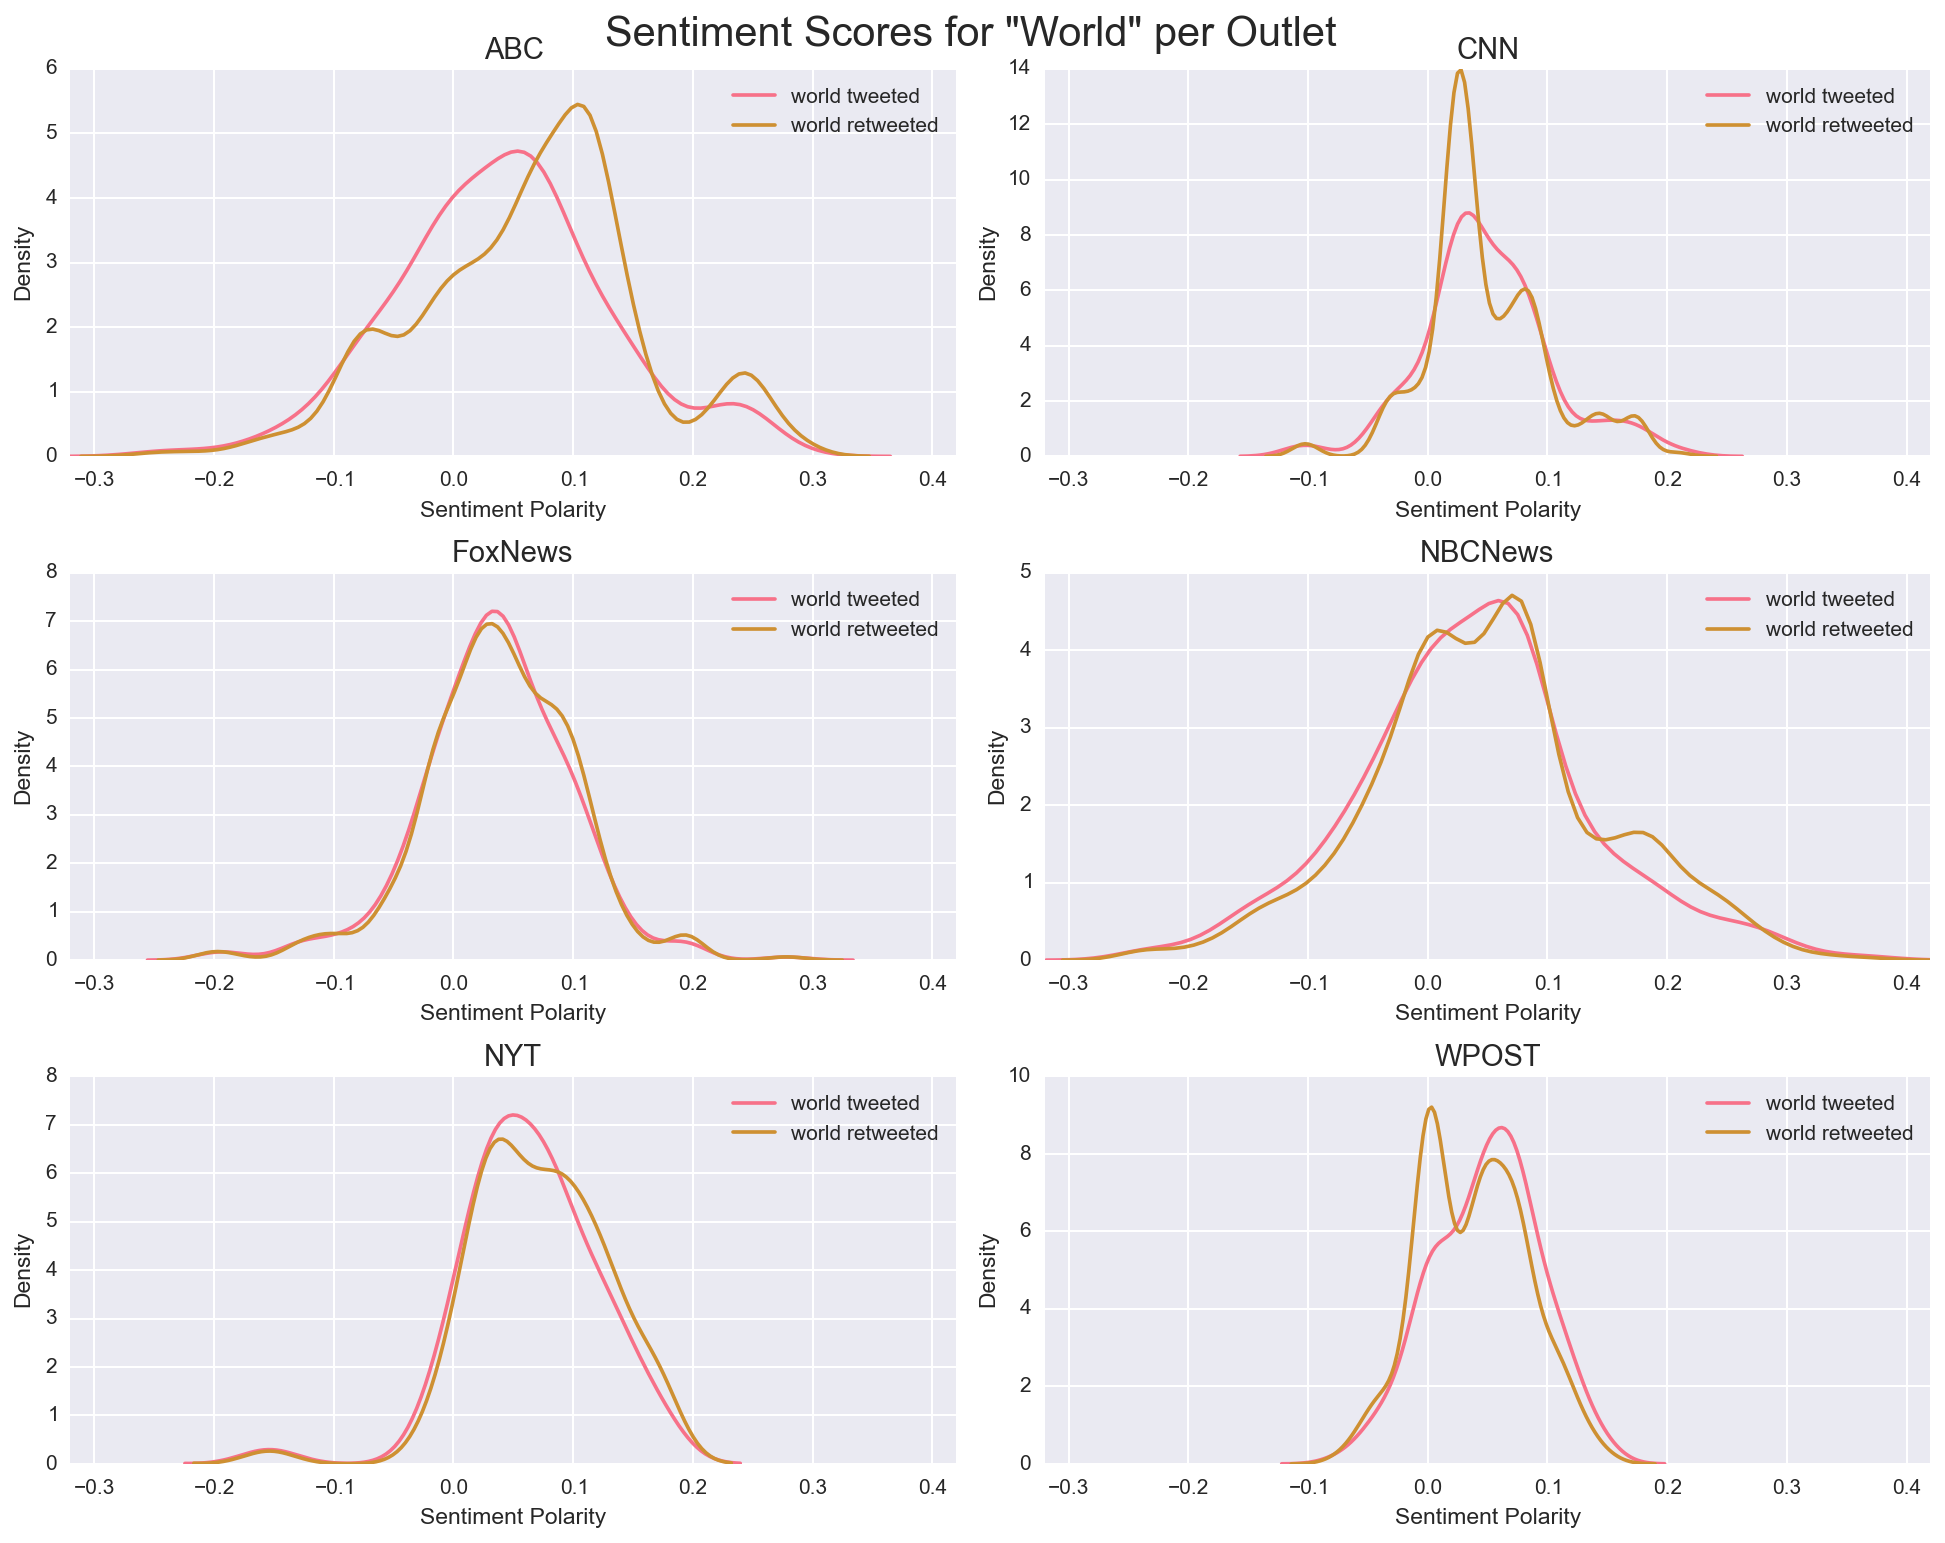

In [25]:
c='world'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
plt.subplots_adjust(hspace=0.3,wspace=0.1)
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o,fontsize=14)
    ax.set_xlabel('Sentiment Polarity')
    ax.set_ylabel('Density')
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax)
    sns.kdeplot(rt,label=c+' retweeted',ax=ax)
f.suptitle('Sentiment Scores for "World" per Outlet', fontsize=20,y=0.94)
plt.savefig('figs/world-per-outlet.png',bbox_inches='tight')

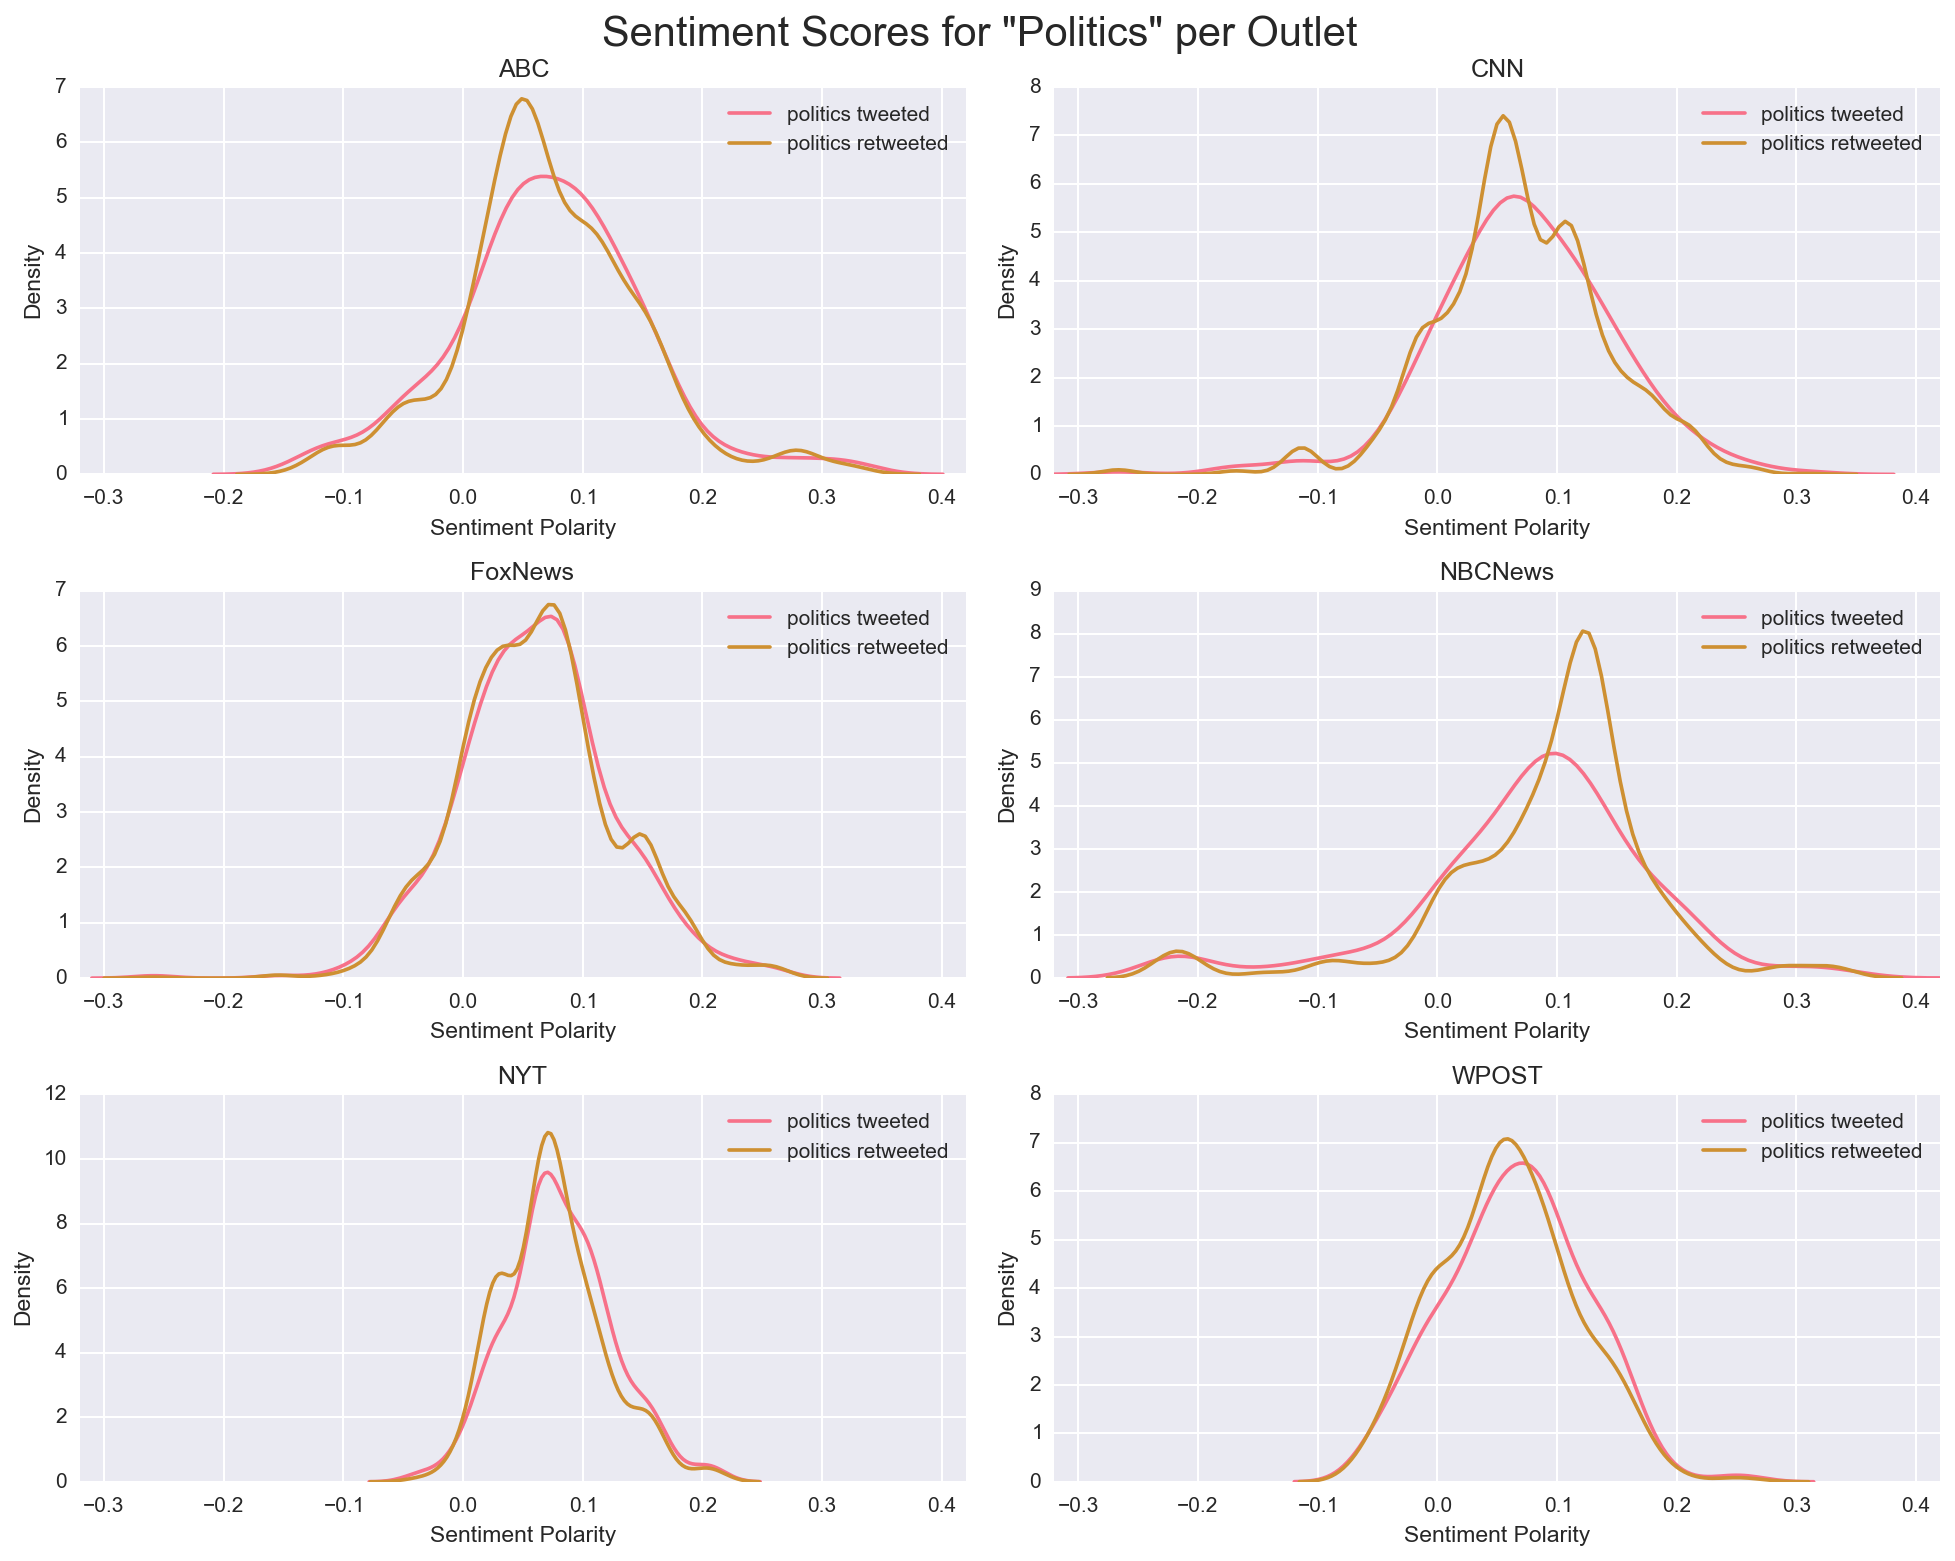

In [26]:
c='politics'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
plt.subplots_adjust(hspace=0.3,wspace=0.1)
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    ax.set_xlabel('Sentiment Polarity')
    ax.set_ylabel('Density')
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax)
    sns.kdeplot(rt,label=c+' retweeted',ax=ax)
f.suptitle('Sentiment Scores for "Politics" per Outlet', fontsize=20,y=0.94)
plt.savefig('figs/politics-per-outlet.png',bbox_inches='tight')

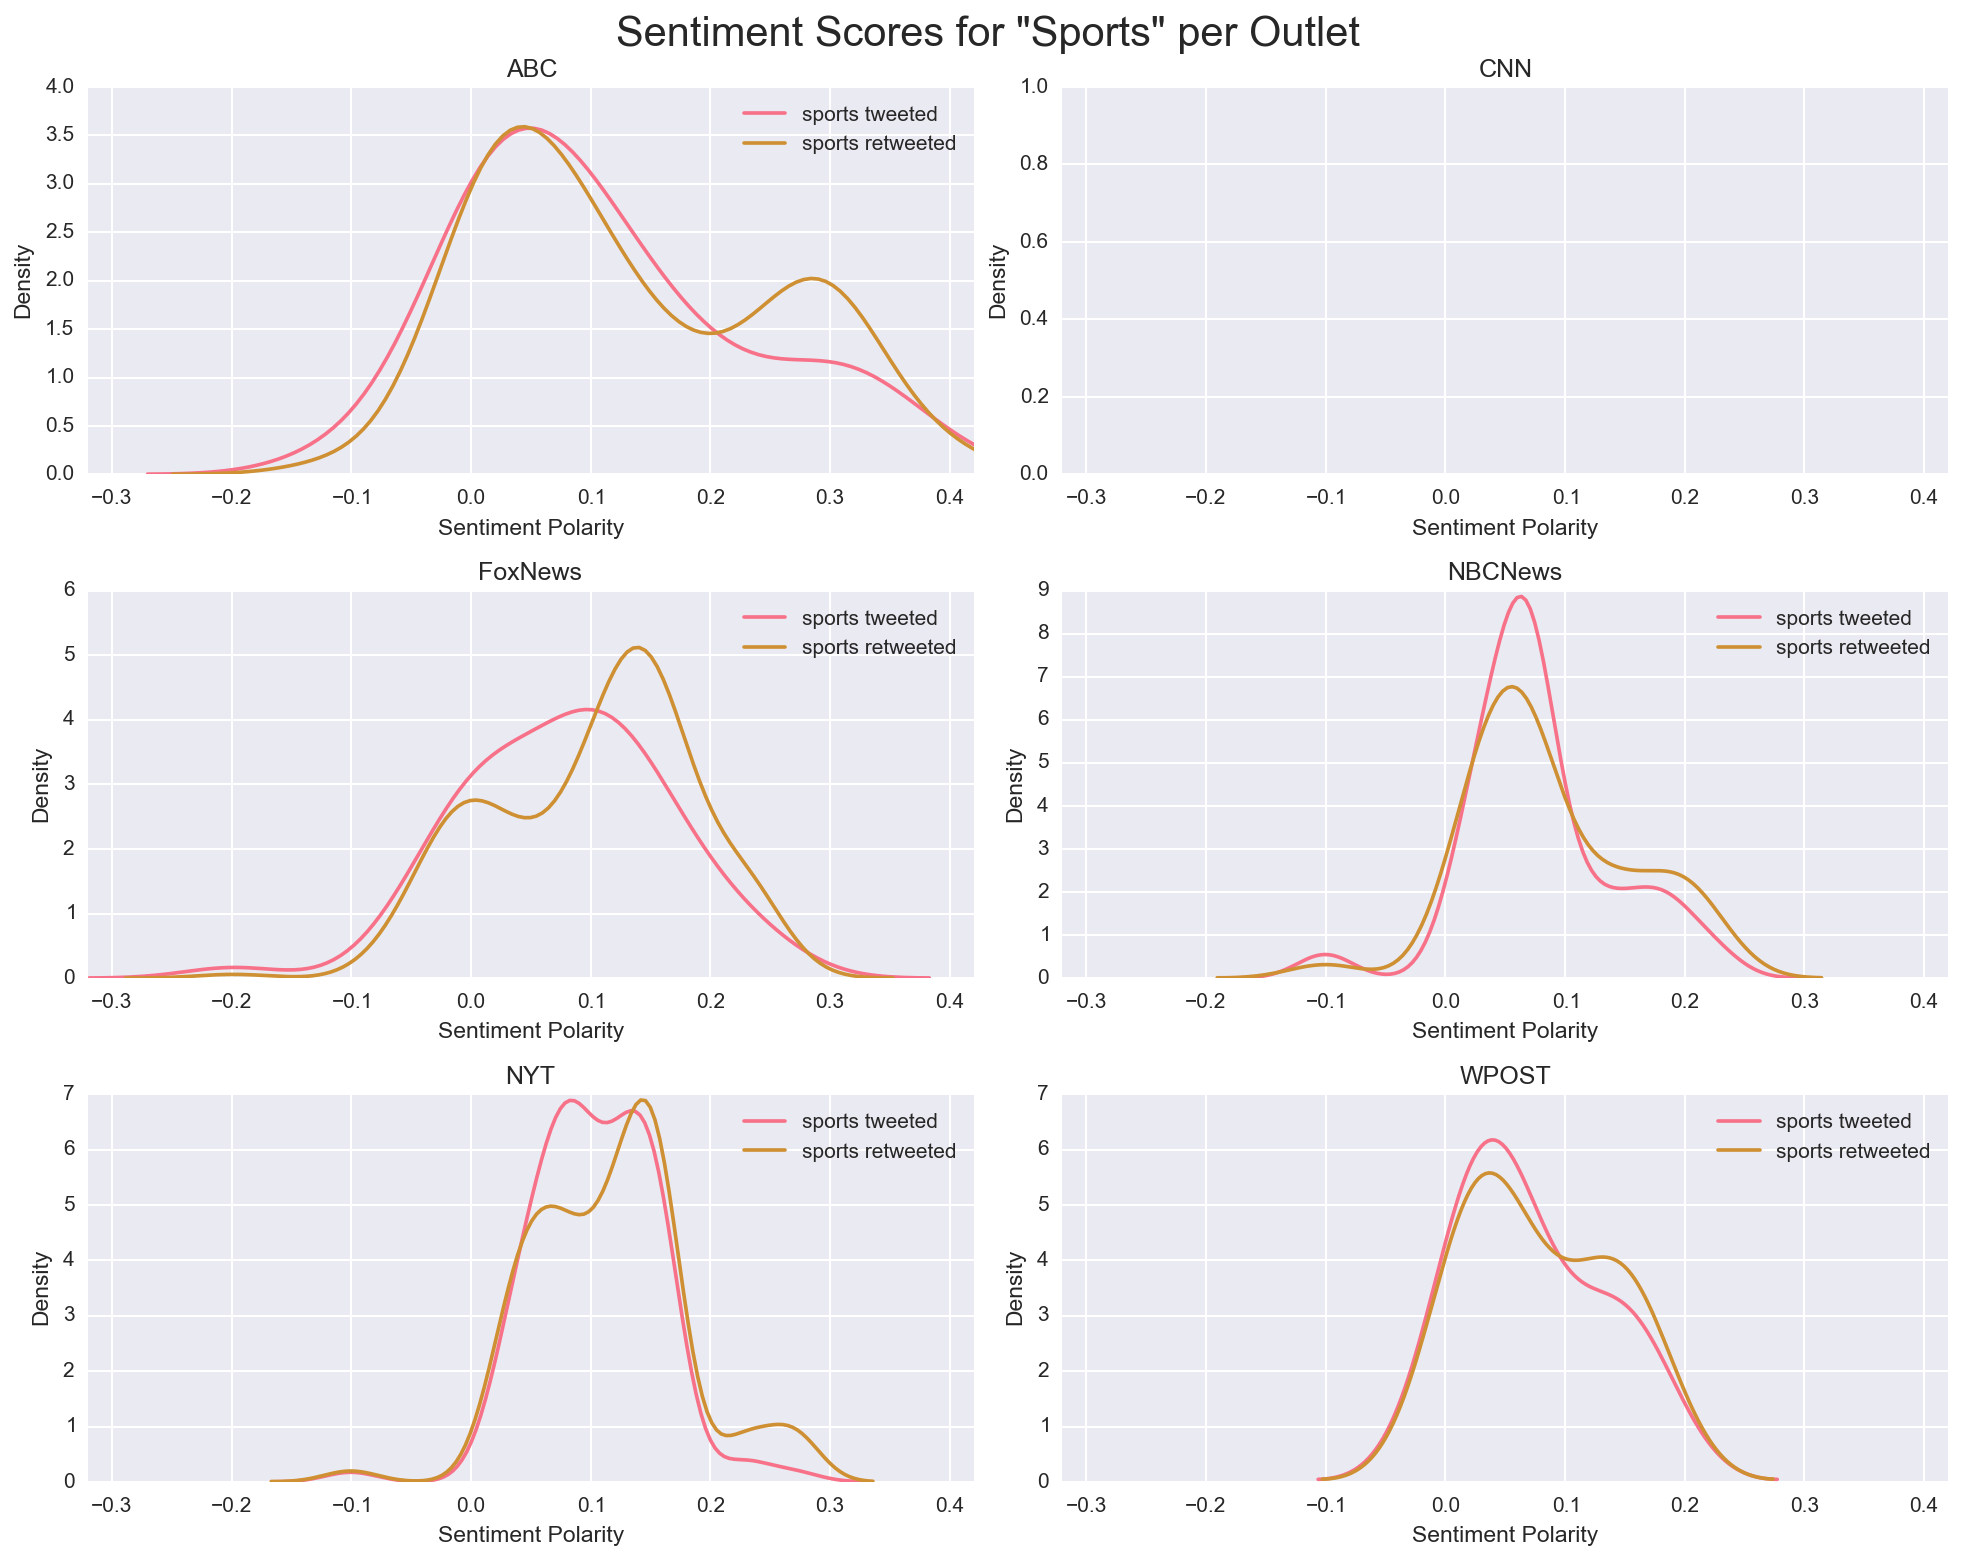

In [27]:
c='sports'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim})
plt.subplots_adjust(hspace=0.3,wspace=0.1)
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    ax.set_xlabel('Sentiment Polarity')
    ax.set_ylabel('Density')
    if o == 'CNN': #CNN does not have sports category in our dataset
        continue
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax)
    sns.kdeplot(rt,label=c+' retweeted',ax=ax)
f.suptitle('Sentiment Scores for "Sports" per Outlet', fontsize=20,y=0.94)
plt.savefig('figs/sports-per-outlet.png',bbox_inches='tight')

In [29]:
tw = df[df['cats'].isin(cs)]
rt = rn[rn['cats'].isin(cs)]
sp = pd.DataFrame(pd.pivot_table(tw,index=['cats'],values='sp',aggfunc=np.mean)).rename(columns={'sp':'Tweeted'})
sp = sp.join(pd.pivot_table(rt,index=['cats'],values='sp',aggfunc=np.mean)).rename(columns={'sp':'Retweeted'})
sp.index.name ='Categories'
sp

,Tweeted,Retweeted
Categories,,
politics,0.068794,0.067125
sports,0.094705,0.111061
world,0.042384,0.049906


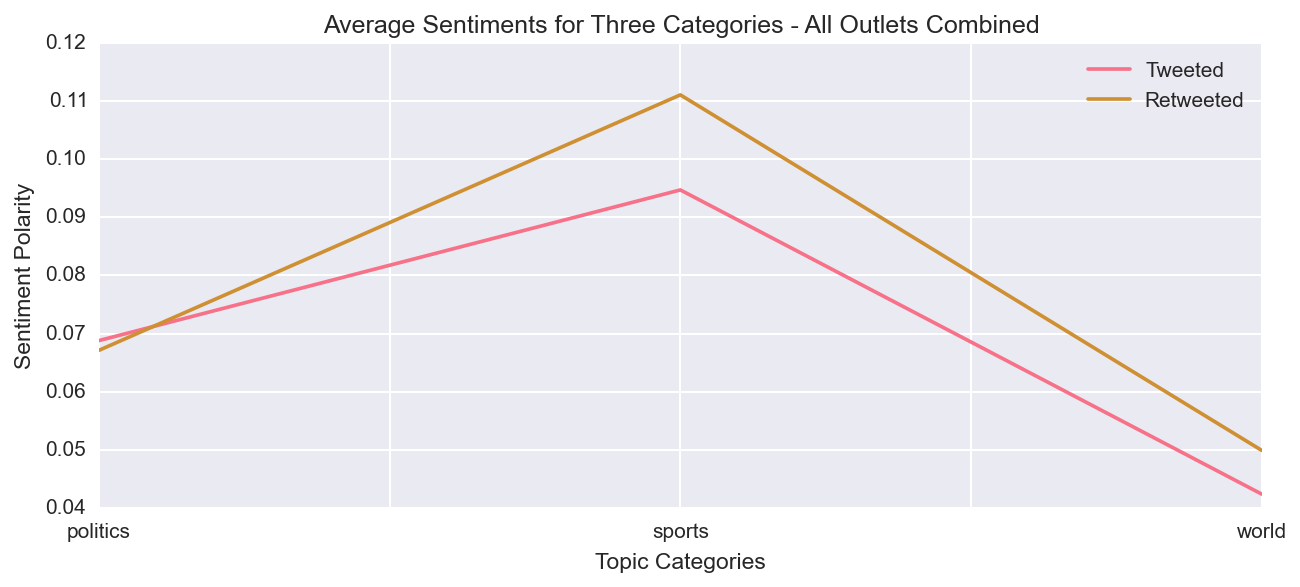

In [30]:
ax = sp.plot()
ax.set_title('Average Sentiments for Three Categories - All Outlets Combined')
ax.set_ylabel('Sentiment Polarity')
ax.set_xlabel('Topic Categories')
plt.savefig('figs/sentiment-averages-per-category.png',bbox_inches='tight')

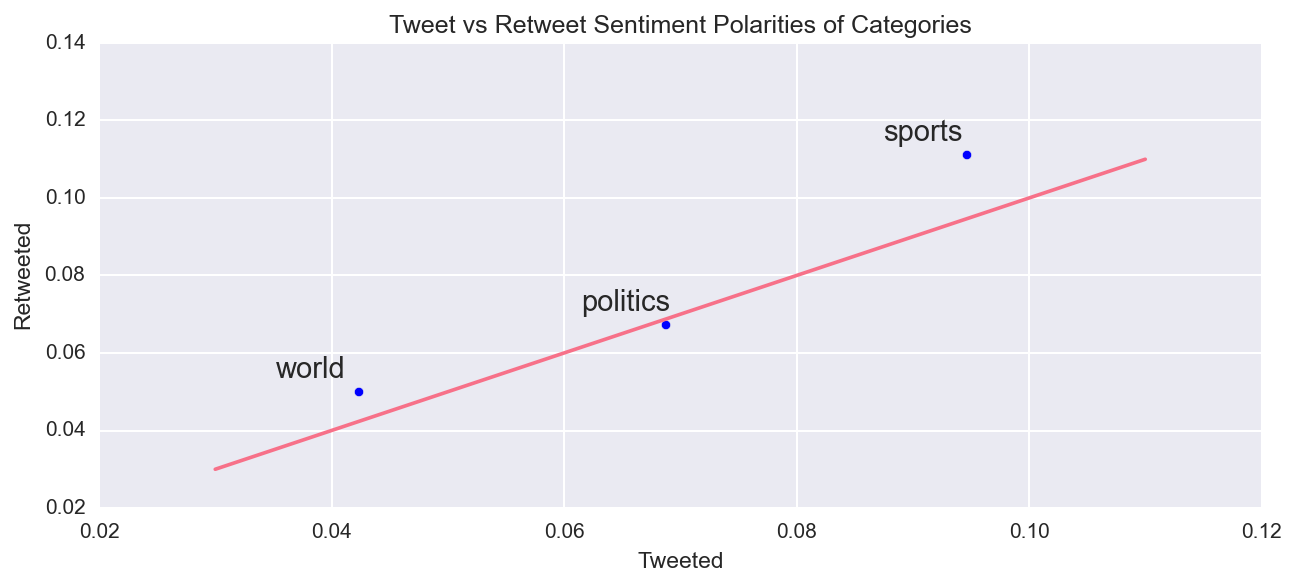

In [65]:
# categories
ax = sp.plot(kind='scatter',x='Tweeted',y='Retweeted',c='blue')
sp.apply(lambda x: ax.annotate(x.name, (x['Tweeted'],x['Retweeted']),
            xytext=(-40, 7), textcoords='offset points',fontsize=14), axis=1)
lims = np.linspace(*ax.get_xlim())
ax.plot(lims, lims)
ax.set_title('Tweet vs Retweet Sentiment Polarities of Categories')
plt.savefig('figs/sentiments-scattered-per-category.png',bbox_inches='tight')